# Nepali Sign Language Recognition - Transfer Learning

# 1. Import required libraries

In [1]:
# Ignore warnings
import logging, os, warnings
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import numpy as np
import random

In [3]:
# Add path for helper_functions
import sys
sys.path.append("/home/aashish/Downloads/Nepali-Sign-Language-Recognition")
from helper_functions import show_images, plot_curves

In [4]:
# Set Devanagari font
plt.rcParams['font.family'] = 'Noto Sans Devanagari'

## 2. Data exploration

In [5]:
data_dir = pathlib.Path("/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['क' 'क्ष' 'ख' 'ग' 'घ' 'ङ' 'च' 'छ' 'ज' 'ज्ञ' 'झ' 'ञ' 'ट' 'ठ' 'ड' 'ढ' 'ण'
 'त' 'त्र' 'थ' 'द' 'ध' 'न' 'प' 'फ' 'ब' 'भ' 'म' 'य' 'र' 'ल' 'व' 'श' 'ष' 'स'
 'ह' '०' '१' '२' '३' '४' '५' '६' '७' '८' '९']


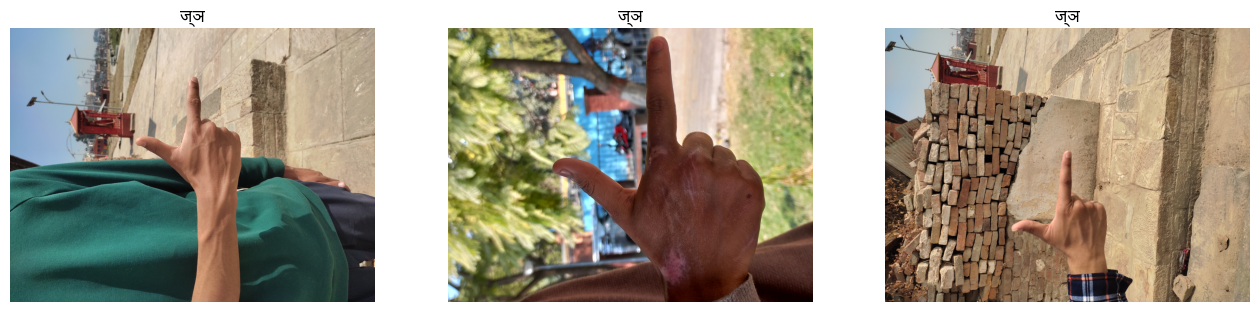

In [7]:
target_directory = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
class_name = "ज्ञ"
show_images(target_directory, class_name)

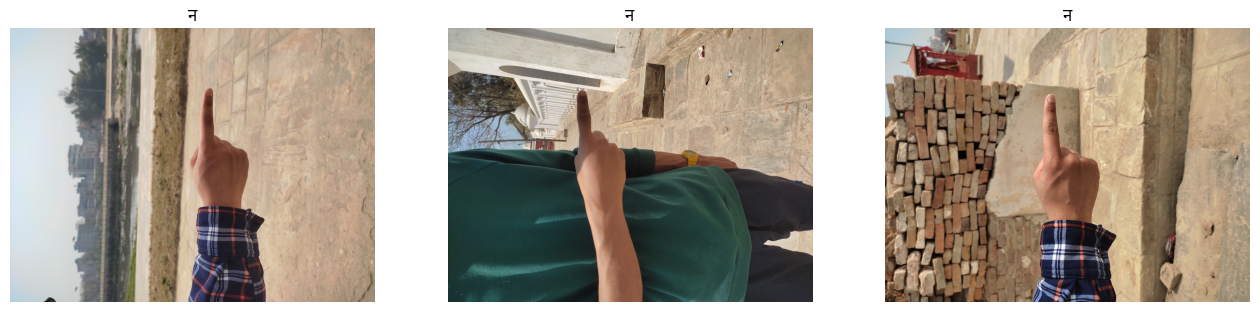

In [8]:
target_directory = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
class_name = "न"
show_images(target_directory, class_name)

## 3. Data Preprocessing

In [9]:
# Define path to train, test and validation set
train_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/train/"
val_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/validation/"
test_dir = "/home/aashish/Downloads/Nepali-Sign-Language-Recognition/Nepali Sign Language Images/test/"

In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical", 
                                                                 image_size=IMG_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir, 
                                                                label_mode="categorical", 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode="categorical", 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False)

Found 1664 files belonging to 46 classes.
Found 357 files belonging to 46 classes.
Found 384 files belonging to 46 classes.


## 4. Model building (feature extraction) 

In [11]:
# Setup data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation_layer")

In [12]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name ="input_layer")
x = data_augmentation(inputs) # augment images
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
eff_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="eff_transfer_learning_model")

In [13]:
eff_model.summary()

Model: "eff_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 46)             │        58,926 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,108,497 (15.67 MB)

 Trainable params: 58,926 (230.18 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

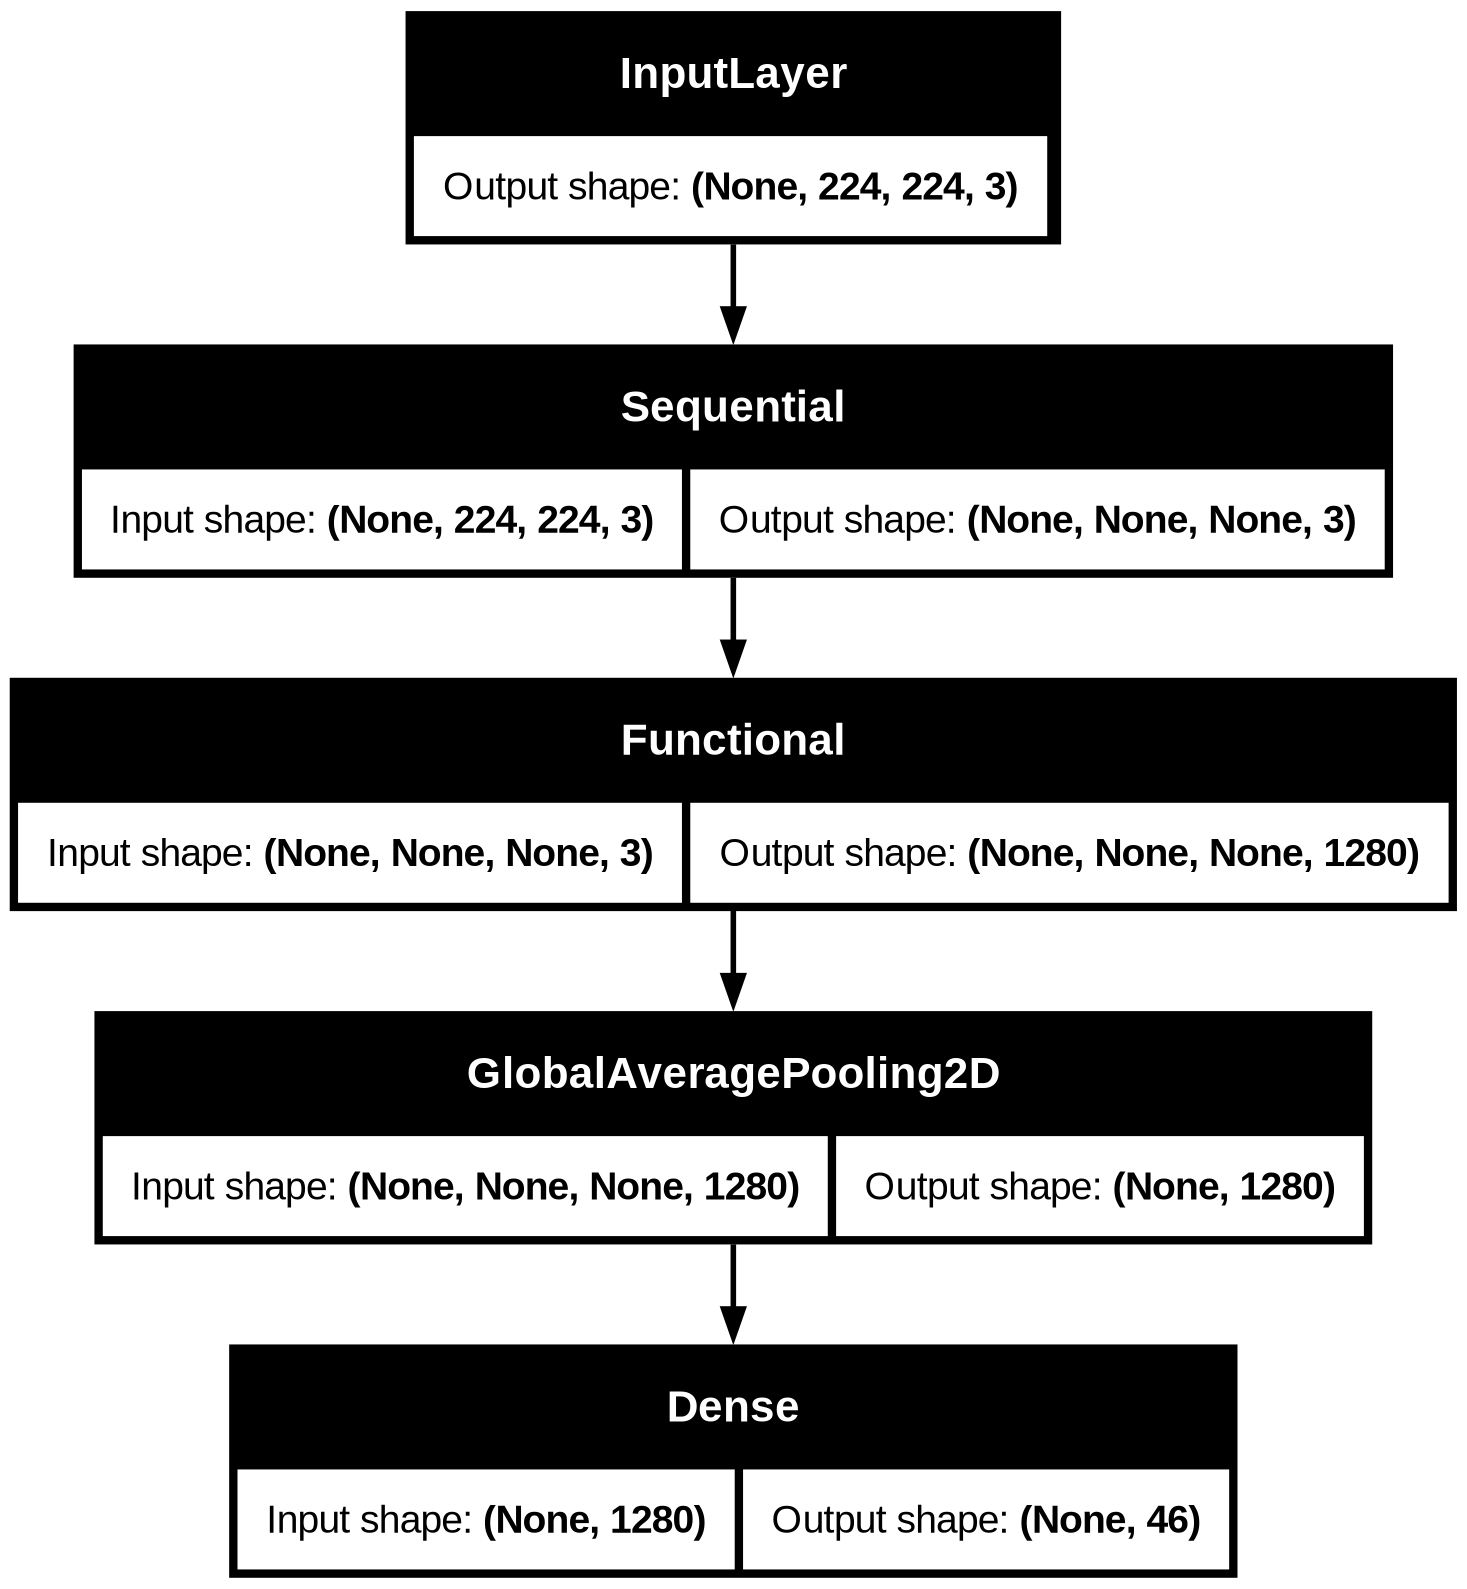

In [14]:
tf.keras.utils.plot_model(eff_model, "eff_transfer_learning_model.png", show_shapes=True)

In [15]:
# Compile the model
eff_model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(), 
              metrics=["accuracy"])

# Fit the model
eff_model_history_1 = eff_model.fit(train_data, 
                              epochs=25, 
                              validation_data=val_data
                             )

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.0491 - loss: 3.8066 - val_accuracy: 0.1765 - val_loss: 3.2418
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.1948 - loss: 3.1276 - val_accuracy: 0.2801 - val_loss: 2.8472
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.3567 - loss: 2.7171 - val_accuracy: 0.3165 - val_loss: 2.6001
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.3954 - loss: 2.4549 - val_accuracy: 0.3501 - val_loss: 2.4124
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.5011 - loss: 2.1714 - val_accuracy: 0.3669 - val_loss: 2.2925
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.5444 - loss: 2.0029 - val_accuracy: 0.3641 - val_loss: 2.1840
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5724 - loss: 1.8900 - val_accuracy: 0.4174 - val_loss: 2.0431
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.6165 - loss: 1.7559 - val_accuracy: 0

In [16]:
# Evaluate the model
eff_model_eval = eff_model.evaluate(test_data)
print(eff_model_eval)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.5661 - loss: 1.5203
[1.397347092628479, 0.6119791865348816]


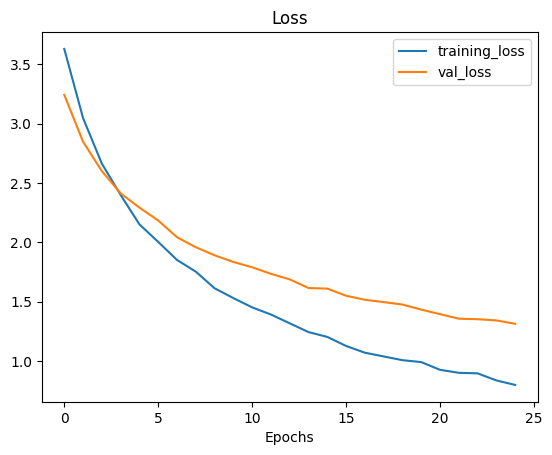

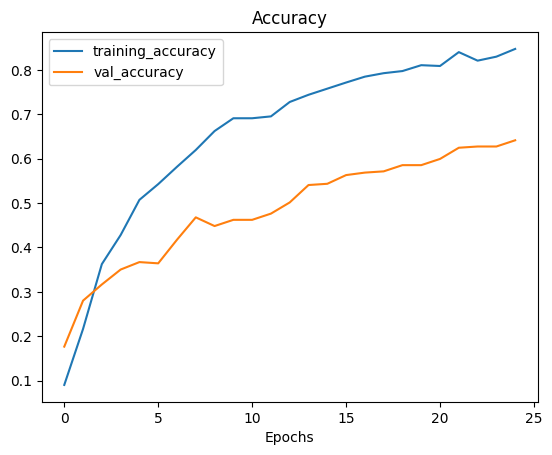

In [17]:
# Restore the default rc settings
plt.rcdefaults()

# Plot loss curves
plot_curves(eff_model_history_1)

## 5. Saving model

In [19]:
eff_model.save("eff_transfer_learning_model.keras")